In [134]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from itertools import product
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


This is another replication analysis in another cohort, PsychENCODE. To run this notebook, you will need to download the data from the website:

1) Go to http://evolution.psychencode.org/#

2) Under the "Processed Data" dropdown, selected mRNA-seq

3) From the "Developmental rhesus and human data", download the following files and put them in the data/ directory:
* mRNA-seq QC (xlsx)
* Gene expression in RPKM: RPKM (txt)

The first part of this notebook is pretty similar to the GTEx and Brainspan notebook

# Prepare pheno data

In [2]:
qc = pandas.ExcelFile('data/mRNA-seq_QC.xlsx').parse('Sheet1',header=2)
qc.head()

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


,Sample,Species,Brain,Sex,Region,NCXRegion,Age,Days,Period,Predicted age (PC Days),Predicted period,Sequencing site,RNA extraction,Platform,RIN,Total reads,Uniquely mapped reads,Multiple reads,Uniquely mapped to ChrM
0,RMB209.AMY,Macaque,RMB209,F,AMY,AMY,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.7,20059352,16691828,1570243,73081
1,RMB209.CBC,Macaque,RMB209,F,CBC,CBC,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.8,24337153,20448575,1628906,105528
2,RMB209.HIP,Macaque,RMB209,F,HIP,HIP,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,9.0,22992437,19436947,1650765,78079
3,RMB209.MD,Macaque,RMB209,F,MD,MD,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,9.0,14859176,12163190,1018555,45757
4,RMB209.DFC,Macaque,RMB209,F,DFC,NCX,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.1,26085236,20635706,3083884,146178


In [3]:
horder = ['8 PCW', '9 PCW', '12 PCW', '13 PCW', '16 PCW', '17 PCW', '19 PCW',
       '21 PCW', '22 PCW', '37 PCW', '4 M', '10 M', '1 Y', '3 Y', '4 Y',
       '8 Y', '11 Y', '13 Y', '15 Y', '19 Y', '21 Y', '23 Y', '30 Y',
       '36 Y', '37 Y', '40 Y']
morder = ['E60', 'E81', 'E82', 'E80', 'E111', 'E110', 'P0','P2', '7M','1Y',
       '2Y', '3.5Y', '4Y', '5Y','7Y', '11Y',]

# stage
fetal = ['8 PCW', '9 PCW', '12 PCW', '13 PCW', '16 PCW', '17 PCW', '19 PCW',
       '21 PCW', '22 PCW', '37 PCW','E60', 'E81', 'E82', 'E80', 'E111', 'E110',]
infant = ['4 M', '10 M', '1 Y','P0','P2','7M','1Y']
child = ['3 Y', '4 Y','8 Y','2Y']
adolescent = ['11 Y', '13 Y', '15 Y', '19 Y','3.5Y', '4Y', '5Y','7Y',]
adult = ['21 Y', '23 Y', '30 Y','36 Y', '37 Y', '40 Y','11Y',]
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    qc.loc[qc[qc.Age.isin(div)].index,'Age_Stage'] = name


mapper = {'Sensorimotor': ['S1C','M1C','MSC'],
          'Limbic': ['HIP','AMY'],
          'Cerebellum': ['CBC','URL'],
          'Striatum': ['STR'],
          'Frontal': ['OFC','VFC','DFC','MFC'],
          'Temporal': ['STC','A1C','ITC','TC'],
          'Parietal': ['IPC','PC',],
          'Occipital': ['V1C','OC'],
          'Thalamus': ['MD','DTH'],
          'Transient': ['LGE','MGE','CGE'],
         }
for name, div in mapper.items():
    qc.loc[qc[qc.Region.isin(div)].index,'MacroStructure'] = name


In [4]:
for i,row in qc.iterrows():
    age = row['Age']
    if age in horder:
        num,measure = age.split(' ')
        if measure == 'PCW':
            fage = int(num)
        elif measure == 'Y':
            fage = (int(num) * 52) + 39.105
        else:
            fage = (int(num) * 4.345) + 39.105
    elif age in morder:
        if 'E' in age:
            fage = int(age.split('E')[1]) / 7
        elif 'P' in age:
            fage = (166 + int(age.split('P')[1])) / 7
        elif 'M' in age:
            fage = (int(age.split('M')[0]) * 4.345) + 23.71
        else:
            fage = (float(age.split('Y')[0]) * 52) + 23.71
    qc.loc[i,'age_in_weeks'] = fage

In [5]:
qc.loc[:,'age_weeks'] = qc.Days.values / 7
#qc.loc[:,'log_age_weeks'] = np.log(qc.age_weeks.values)
qc.loc[:,'log_age_weeks'] = np.log(qc.age_in_weeks.values)

In [6]:
hcode = dict(zip(horder,range(len(horder))))
mcode = dict(zip(morder,range(len(morder))))
for i,row in qc.iterrows():
    age = row['Age']
    if age in horder:
        qc.loc[i,'age_level'] = hcode[age]
    elif age in morder:
        qc.loc[i,'age_level'] = mcode[age]
    else:
        print(age,'not found')

# Get components

In [7]:
df = pandas.read_csv('data/nhp_development_RPKM_rmTechRep.txt',sep='\t')
df.loc[:,'future_ind'] = [x.split('|')[-1] for x in df.index.values]
df.index = range(len(df))
print(df.shape)

(27932, 827)


In [8]:
dups = []
dind = []
catch = []
for i,row in df.iterrows():
    x = row['future_ind']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

In [12]:
df.drop(dind,inplace=True)
df.index = df.future_ind.values
df.drop('future_ind',axis=1,inplace=True)
df.shape

(27693, 826)

In [13]:
allcomps = pandas.read_csv('./tables/all_comps.csv',index_col=0)
allcomps.index = allcomps.gene_symbol.values
allcomps.head()
shared = set(df.index.values) & set(allcomps.index)
df = df.loc[shared]

In [14]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [15]:
hbigdf = hbigdf[df.index]

In [16]:
# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

In [17]:
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [18]:
df.shape

(13087, 826)

In [19]:
hbigdf.shape

(3466, 13087)

In [20]:
# Minmax
adulthuman = df[qc[(qc.Species=='Human') & (qc.Age_Stage=='adult')].Sample.values]
mmmod = MinMaxScaler().fit(adulthuman.T)
hb_pcatfm = pcamod.transform(mmmod.transform(df[qc.Sample.values].T))
xtfm = pls_mod.transform(hb_pcatfm)

In [21]:
for i in range(3):
    qc.loc[:,'C%s_exp'%(i+1)] = xtfm[:,i]

# Validate

In [22]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data_ROTATION.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(qc.MacroStructure.unique()))
print('missing:',set(qc.MacroStructure.unique()) - set(abac2.index))

bsc2 = pandas.pivot_table(#qc,
                            qc[(qc.Age_Stage=='adult') & (qc.Species=='Human')],
                          values='C2_exp',
                             index='MacroStructure',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = qc[(qc.Age_Stage=='adult') & (qc.Species=='Human') & (qc.MacroStructure==div)
            ]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

shared: {'Thalamus', 'Occipital', 'Frontal', 'Cerebellum', 'Limbic', 'Parietal', 'Sensorimotor', 'Temporal', 'Striatum'}
missing: {'Transient'}


,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,-0.271709,0.086946,-0.706893,0.019982,Cerebellum
Frontal,0.573367,0.167683,0.789432,0.031165,Frontal
Limbic,0.565131,0.128855,0.030956,0.039398,Limbic
Occipital,-1.079097,0.219612,-1.655174,0.042085,Occipital
Parietal,-0.631850,0.194580,-1.124981,0.031968,Parietal


In [23]:
n_comps = 3
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(qc.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    qc.loc[:,'zC%s_exp'%i,] = vals

r = 0.977, p = 0.0


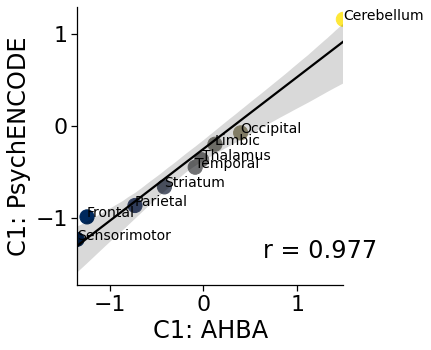

r = 0.964, p = 0.0


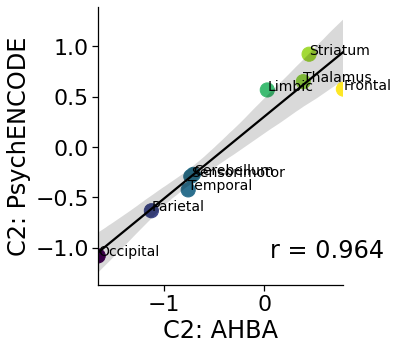

r = 0.901, p = 0.001


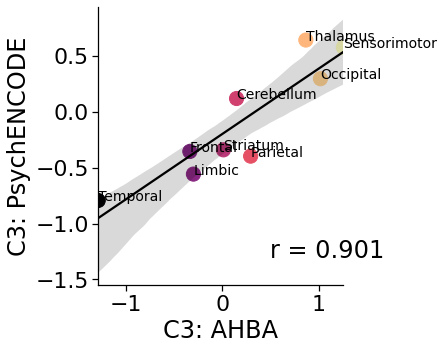

In [24]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            qc[(qc.Age_Stage=='adult') & (qc.Species=='Human')],# just the human adultss!
                          values='C%s_exp'%i,
                             index='MacroStructure',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = qc[(qc.Age_Stage=='adult') & (qc.Species=='Human') & (qc.MacroStructure==div)
                 ]['C%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['PEC_mean','PEC_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='PEC_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.PEC_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'PEC_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: PsychENCODE'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(figdir,'PsyENC_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

# Validate human development

In [25]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = qc[['Brain','C%s_exp'%i,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%s_exp'%i)
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [26]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [27]:
# build a summary dataframe at the indexed by subjects

cols = ['Sample', 'Species', 'Brain', 'Sex', 'Region', 'NCXRegion', 'Age',
       'Days', 'Period', 'Predicted age (PC Days)', 'Predicted period',
       'Sequencing site', 'RNA extraction', 'Platform', 'RIN', 'Total reads',
       'Uniquely mapped reads', 'Multiple reads', 'Uniquely mapped to ChrM',
       'Age_Stage', 'MacroStructure', 'age_weeks', 'log_age_weeks','age_level']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = qc.groupby('Brain')[col].first().loc[gpdfs[1].index].values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [29]:
fig_dir = './figures/'

>>>>>>>> Macaque <<<<<<<<
r=0.469, p=0.0209


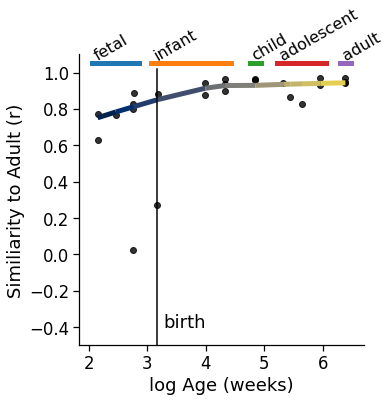

r=0.79, p=0.0


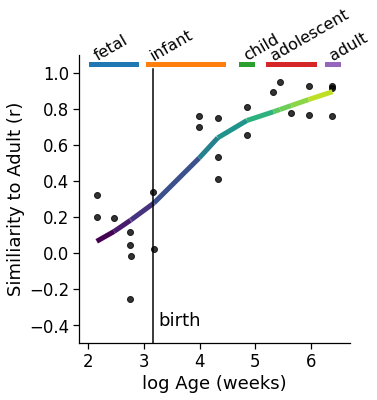

r=0.768, p=0.0


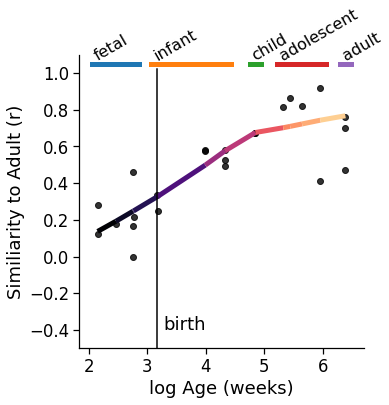

>>>>>>>> Human <<<<<<<<
r=0.636, p=0.0001


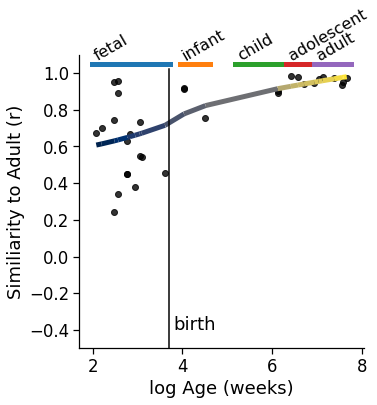

r=0.784, p=0.0


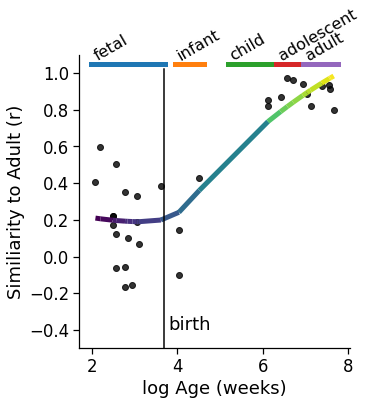

r=0.681, p=0.0


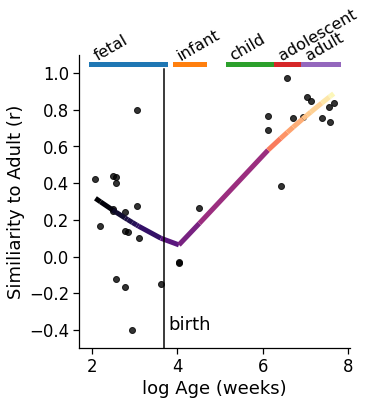

In [30]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

for species in qc.Species.unique():
    print('>'*8,species,'<'*8)
    sns.set_context('notebook',font_scale=1.5)
    # for each component
    for c in range(1,(n_comps+1)):
        # plot
        g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                    lowess=True,
                     scatter_kws={'color':'k'},
                   data=subsum[subsum.Species==species])
        plotr = pandas.DataFrame(subsum[subsum.Species==species][['C%s_r'%c,'age_level']],
                                copy=True).dropna()
        # get stats
        r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                          plotr.age_level.values)
        print('r=%s, p=%s'%(round(r,3),round(p,4)))

        # make line purty
        x, y = g.ax.get_lines()[0].get_data()
        segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
        norm = plt.Normalize(x.min(), x.max())
        lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
        lc.set_array(x[:-1])
        lc.set_linewidth(2)
        g.ax.get_lines()[0].remove()
        line = g.ax.add_collection(lc)
        plt.setp(line,linewidth=5)

        # decorate so age stage is indicated
        for stage in qc[qc.Species==species].Age_Stage.unique():
            levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
            xmin = np.min(levels) -0.1
            xmax = np.max(levels) +0.1
            plt.plot([xmin,xmax],[1.05,1.05],lw=5)
            #loc = xmin + (xmax-xmin)*.5
            plt.text(xmin,1.05,stage,fontsize=16,ha='left',
                     va='bottom',rotation=30)
        # further decorate
        plt.ylabel('Similiarity to Adult (r)')
        plt.xlabel('log Age (weeks)',)#fontsize=30)
        plt.ylim(-0.5,1.1)
        ymin = subsum['C%s_r'%c].min() - 0.1
        if species == 'Human':
            plt.axvline(np.log(40),ymax=0.95,c='k')
            plt.text(np.log(40)+0.1,-0.4,'birth')
        else:
            plt.axvline(np.log(23.714),ymax=0.95,c='k')
            plt.text(np.log(23.714)+0.1,-0.4,'birth')
#         plt.savefig(os.path.join(fig_dir,'PEC_%s_CompR_C%s.pdf'%(species,c)), 
#                                  bbox_inches='tight')
        plt.show()
    

In [31]:
# Let's plot all those lines on one plot

devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_weeks'] = subsum.age_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3
devplot.loc[:,'Species'] = subsum.Species.tolist() * 3

>>>>>>>> Macaque <<<<<<<<


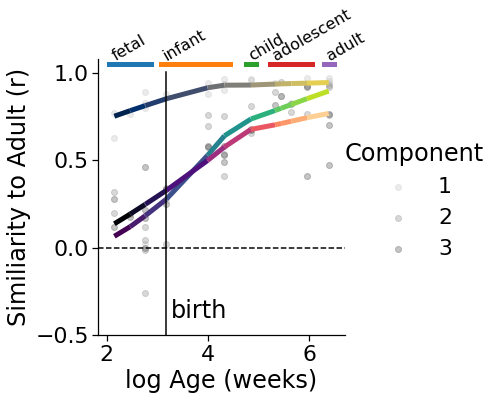

>>>>>>>> Human <<<<<<<<


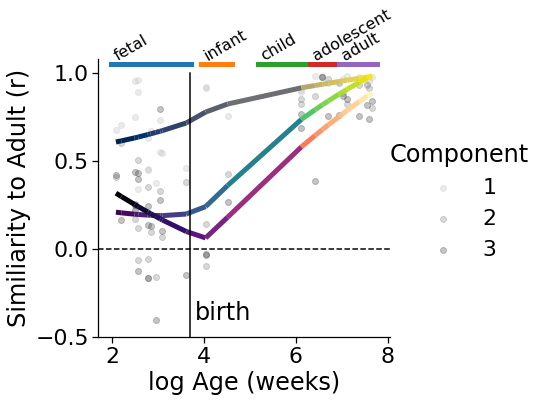

In [34]:
sns.set_context('notebook',font_scale=2)
for species in qc.Species.unique():
    print('>'*8,species,'<'*8)
    g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
                 hue_order=['1','2','3'],palette='binary',
                   data=devplot[devplot.Species==species],scatter_kws={'alpha':0.3})
    g.ax.set_ylim(-0.5,1.08)
    #g.set_xticklabels(rotation=90)
    if species == 'Human':
        plt.axvline(np.log(40),ymax=0.95,c='k')
        plt.text(np.log(40)+0.1,-0.4,'birth')
    else:
        plt.axvline(np.log(23.714),ymax=0.95,c='k')
        plt.text(np.log(23.714)+0.1,-0.4,'birth')
    for i in range(3):
        # make line purty
        x, y = g.ax.get_lines()[i].get_data()
        segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
        norm = plt.Normalize(x.min(), x.max())
        lc = LineCollection(segments, cmap=pals[i], norm=norm)
        lc.set_array(x[:-1])
        lc.set_linewidth(2)
        line = g.ax.add_collection(lc)
        plt.setp(line,linewidth=5)
    for i in range(3):
        g.ax.get_lines()[0].remove()

    for stage in qc[qc.Species==species].Age_Stage.unique():
        levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
        xmin = np.min(levels) -0.1
        xmax = np.max(levels) +0.1
        plt.plot([xmin,xmax],[1.05,1.05],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.05,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.axhline(0,ls='--',c='k')
    #plt.ylim(-0.28,1.1)
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)')
#     plt.savefig(os.path.join(fig_dir,'PEC_%s_CompR_overlay_ROTATED.pdf'%species),
#                 bbox_inches='tight')
    plt.show()


# Replicate early patterning genes from Brainspan
In the Brainspan notebook, we identified different genes that appear to be spatially distributed in an LV-like way throughout development, including prenatally. Here, we will make sure those genes show similar patterns in this separate dataset. 

**Note:** All of the following code requires the Brainspan notebook having been run, as it uses data that was generated from that notebook.

Again, we'll have to do this LV by LV, so...
### C1

In [41]:
c1_genes = pandas.read_csv('data/C1_devclusters_12clus.csv',index_col=0)
#c1_genes = pandas.read_csv('data/C1_devclusters_4clus.csv',index_col=0)
c1_genes.head()

,Gene,Cluster
0,PRRX1,4
1,WFDC1,8
2,AMDHD1,6
3,CTXN3,1
4,GPR20,0


First we need to run the same analysis where we look at how similar gene expression is to the LV1.

In [42]:
# create individual dfs for each component

c=1
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [43]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [44]:
subsum.index = subsum.Brain.values

### Plot genes that were non-transitional for Brainspan

First let's get a general sense of whether the genes found to be important and non-transitional in Brainstem are mostly non-transitional in GTEx

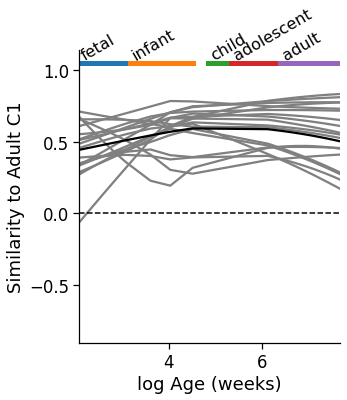

In [45]:
# plot the trajectory of all genes in cluster 5
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_4Clus1.pdf'),bbox_inches='tight')

While there are some exceptions, this seems to be generally the case. There is a bit more of an upward trend of many genes, but the LV1 similarity is pretty high

### Apply the brainspan clustering solution PEC data?
Probably the most unbiased way to do this is to find a way to "apply" the Brainspan clustering solution to the PEC data and see which PEC genes fall into the non-transitional cluster. If a gene falls into the non-transitional cluster across both datasets, that's a pretty strong and data-driven indication that the gene has a reproducible pattern across datasets of being non-transitional and LV-associated.

This is a tricky proposition since agglomerative clustering doesn't have a "transform" or "predict" method. Instead, we'll measure distance of each gene to each cluster centroid. But in order to do that, we'll need to ensure the data is in roughly the same space.

In [49]:
c1tall = pandas.read_csv('data/BSDevGens_C1_12clus.csv',index_col=0)

In [50]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

As a reminder, we'll plot the Brainspan LV1 clusters

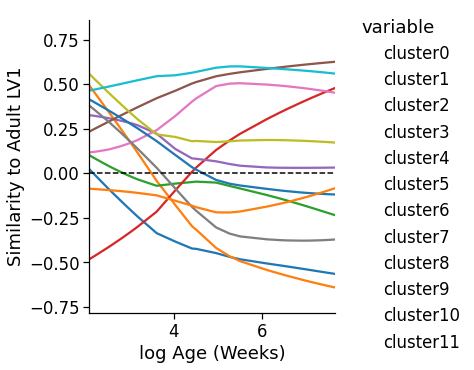

In [51]:
# plot the trajectory of all clusters
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab10',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=c1tall)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (Weeks)')
plt.axhline(0,c='k',ls='--')


In [52]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [53]:
subsum1.index = subsum1.Brain.values

In [54]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [55]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [56]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    if any(gvec.values<0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 0
    if any(gvec.values>0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
    

Find genes that are:

a) Non-transitional in Brainspan (Cluster 9)

b) Are part of the same cluster in PEC

c) Have no samples that are ever negatively related to LV1

d) Have at least one sample with an r-value > 0.5 (expression similarity to LV1)

In [58]:
replicated = c1_genes[(c1_genes.Cluster==9) & (c1_genes.PEC_Human_Cluster==9) &\
                     (c1_genes.PEC_Gene_Ever_Negative==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

SPON2
SP5
ZIC1
TLL1
C14orf132
LIMK2
LGR6
CCDC88B


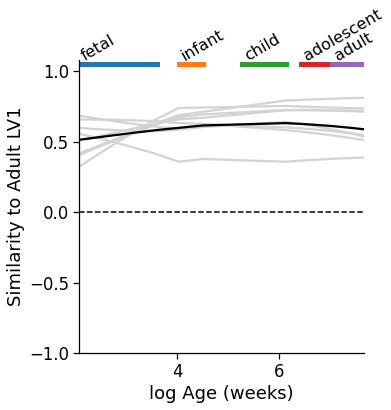

In [59]:
# plot the trajectory of all replicated genes for the purposes of example figure

repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C1'] = fitted['C1'][i]
    inds = hum_mapping[x]
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_Clus9_PEC.pdf'),
#             bbox_inches='tight')

### Overlay against C1 trajector for PEC and BS

Now that we found the genes that replicate, let's plot them overlaid against the LV1 trajectory

#### PEC

Text(3.7888794541139363, 0.1, 'birth')

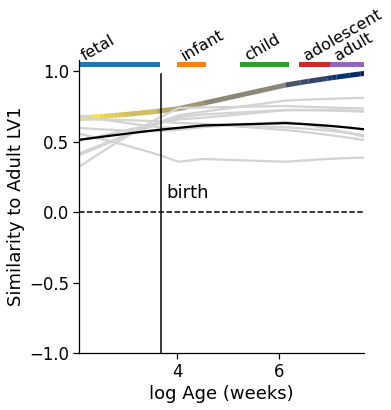

In [60]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C1'] = fitted['C1'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C1'] = subsum.loc[inds]['C1_r'].mean()
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C1.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C1_4Clu1vAll_PEC.pdf'),
#             bbox_inches='tight')

Now the same for Brainspan

In [61]:
# bs
bsc9 = pandas.read_csv('data/BSDevGens_C1_ss_4clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [62]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [63]:
bs_subsum.index = bs_subsum.donor_id.values

Text(3.7888794541139363, 0.1, 'birth')

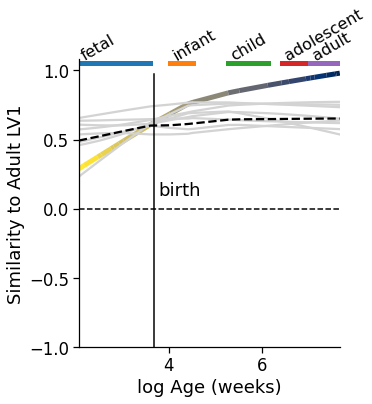

In [64]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C1'] = bs_subsum.loc[repplots_bs.index,'C1_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())

g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='black',line_kws={'ls':'--'},
           marker='',lowess=True)
m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C1.values,
            color='gray',
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C1_4Clu1vAll_BS.pdf'),
#             bbox_inches='tight')

# C2
Now we repeat all of that for LV2

In [65]:
c1_genes = pandas.read_csv('data/C2_devclusters.csv',index_col=0)
#c1_genes = pandas.read_csv('data/C1_devclusters_4clus.csv',index_col=0)
c1_genes.head()

,Gene,Cluster
0,MGP,0
1,MET,0
2,TDRD1,1
3,LXN,1
4,CPLX2,0


In [66]:
# create individual dfs for each component
c = 2
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
#     subsum1.loc[:,'%s_r'%gene] = gpdf.loc[subsum1.index,'%s_r'%gene].values
#     subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[subsum1.index,'%s_rho'%gene].values
#     subsum1.loc[:,'n_valid'] = gpdf.loc[subsum1.index,'n_valid'].values
    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [67]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [68]:
subsum.index = subsum.Brain.values

### Plot genes that were non-transitional for Brainspan

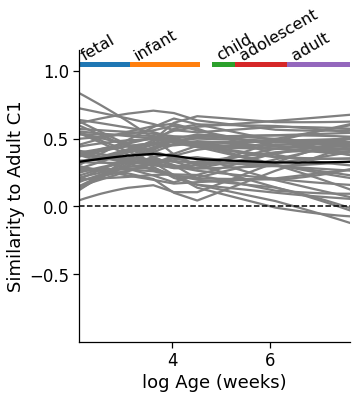

In [69]:
# plot the trajectory of all genes in cluster 5
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_7Clus3.pdf'),bbox_inches='tight')

### Apply the brainspan cluster solution to PEC data

In [70]:
c1tall = pandas.read_csv('data/BSDevGens_C2_7clus.csv',index_col=0)

In [71]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

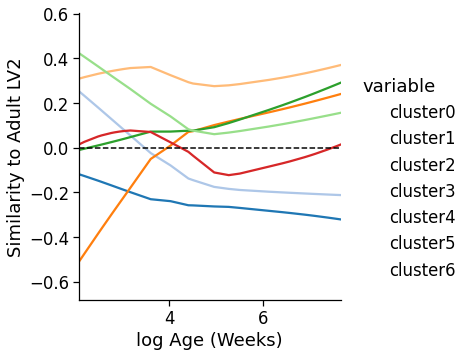

In [72]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=c1tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (Weeks)')

plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In [73]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [74]:
subsum1.index = subsum1.Brain.values

In [75]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [76]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [77]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    if any(gvec.values<0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 0
    if any(gvec.values>0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0

    

In [78]:
replicated = c1_genes[(c1_genes.Cluster==3) & (c1_genes.PEC_Human_Cluster==3) &\
                     (c1_genes.PEC_Gene_Ever_Negative==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

FANK1
LRRN1
KCNA5
SKAP1
VWA5A
RBP1
SIX3
MGAT4C
HRH3
HSPB8
ZMYND10


### Overlay against C2 trajector for PEC and BS

#### PEC

Text(3.7888794541139363, 0.1, 'birth')

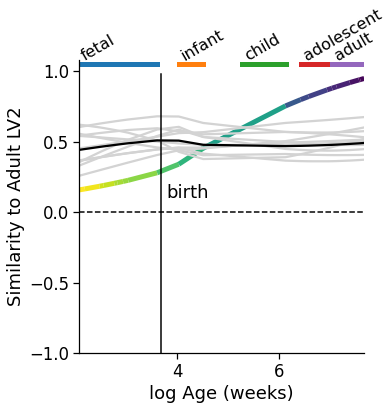

In [80]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
# drop 2 genes that didn't pass criteria in brainspan
#repcols = [x for x in repcols if x not in ['TSHZ1_r','GLCE_r']]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C3'] = fitted['C3'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C2'] = subsum.loc[inds]['C2_r'].mean()
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',
             palette=['lightgray']*len(rtall.variable.unique()),
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C2.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C2_7Clu3vAll_PEC.pdf'),
#             bbox_inches='tight')

In [81]:
# bs
bsc9 = pandas.read_csv('data/BSDevGens_C2_ss_7clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [82]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [83]:
bs_subsum.index = bs_subsum.donor_id.values

Text(3.7888794541139363, 0.1, 'birth')

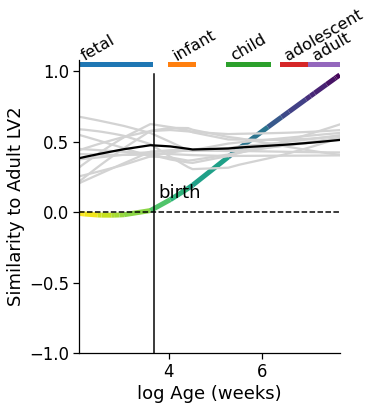

In [84]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C2'] = bs_subsum.loc[repplots_bs.index,'C2_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)
m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C2.values,
            color='gray',
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C2_7Clu3vAll_BS.pdf'),
#             bbox_inches='tight')

# C3
Now one more time for C3

In [85]:
c1_genes = pandas.read_csv('/Users/jacobv/git/Vogel_PLS_Tx-Space/data/C3_devclusters.csv')
c1_genes.head()

,Unnamed: 0,Gene,Cluster
0,0,MGP,11
1,1,TNFSF13B,11
2,2,CYP26B1,2
3,3,PNMT,9
4,4,C1R,7


In [86]:
c1_genes = pandas.read_csv('data/C3_devclusters.csv',index_col=0)
c1_genes.head()

,Gene,Cluster
0,MGP,11
1,TNFSF13B,11
2,CYP26B1,2
3,PNMT,9
4,C1R,7


In [87]:
# create individual dfs for each component
c = 3
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue

    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [88]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==15].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [89]:
c5plots.iloc[:,:-2].mean(0).sort_values(ascending=False)

ARHGAP29_r   -0.039453
C1S_r        -0.083685
RCSD1_r      -0.117494
DSP_r        -0.121626
FRZB_r       -0.141408
FILIP1L_r    -0.176563
dtype: float64

### Plot genes that were non-transitional for Brainspan

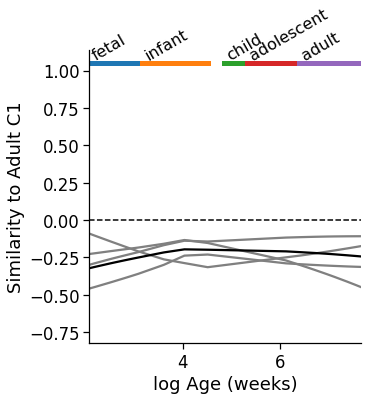

In [91]:
# plot the trajectory of all genes in cluster 16
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==16].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines_17Clus15.pdf'),bbox_inches='tight')

### What if we apply the brainspan cluster solution PEC data?

In [105]:
c1tall = pandas.read_csv('data/BSDevGens_C3_17clus.csv',index_col=0)

In [106]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

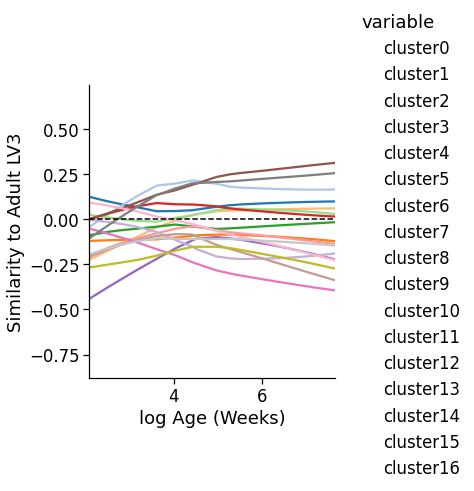

In [107]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             data=c1tall)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (Weeks)')


plt.axhline(0,c='k',ls='--')


In [109]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [110]:
subsum1.index = subsum1.Brain.values

In [111]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==16].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [113]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [114]:
mapped

,PID1_r,ERLIN1_r,LIG1_r,RHCG_r,ind,log_age_weeks
2.079442,-0.280069,0.258954,0.505244,0.076927,0.0,2.079442
2.197225,-0.098669,-0.126395,0.191073,-0.079366,1.0,2.197225
2.484907,-0.422083,-0.312331,-0.179655,-0.463818,3.0,2.484907
2.564949,-0.512237,-0.465254,-0.296833,-0.470159,6.0,2.564949
2.772589,-0.398698,-0.025843,-0.284535,-0.150782,9.0,2.772589
2.833213,-0.302223,-0.080377,-0.2671,-0.268671,11.0,2.833213
2.944439,-0.706876,-0.508249,-0.373941,-0.197694,12.0,2.944439
3.044522,-0.23369,-0.213209,-0.123509,-0.008653,14.0,3.060029
3.610918,-0.383332,-0.068334,-0.173659,-0.227947,16.0,3.610918
4.033975,-0.199135,-0.038772,-0.241464,-0.147169,17.5,4.033975


In [115]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    # notice we're changing to "Ever Positive" here because the relationship is negative
    if any(gvec.values>0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 0
    if any(gvec.values<-0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
    

In [118]:
replicated = c1_genes[(c1_genes.Cluster==16) & (c1_genes.PEC_Human_Cluster==16) &\
                     (c1_genes.PEC_Gene_Ever_Positive==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

PID1


### Overlay against C2 trajector for PEC and BS

#### PEC

For consistency and to assail confusion, we will invert the value for genes in this cluster. Again, nothing sneaky here -- a negative or a positive relationship indicates similarity to LV expression, as it has two tails and genes from both tails are represented

Text(3.7888794541139363, 0.1, 'birth')

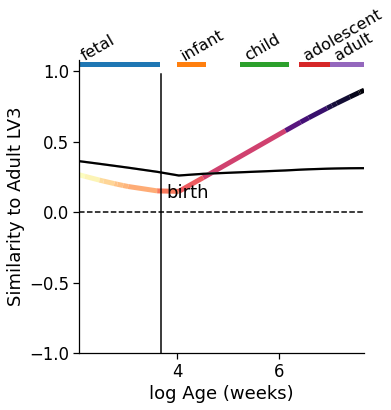

In [119]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C15'] = fitted['C15'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C3'] = subsum.loc[inds]['C3_r'].mean()
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())

# invert
rtall.loc[:,'value'] = rtall.loc[:,'value'].values * -1
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=(repplots[repcols].mean(1).values *-1),
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C3.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='magma_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C3_17Clu15vAll_PEC.pdf'),
#             bbox_inches='tight')

In [120]:
# bs
bsc9 = pandas.read_csv('data/BSDevGens_C3_ss_17clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [121]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [122]:
bs_subsum.index = bs_subsum.donor_id.values

Text(3.7888794541139363, 0.1, 'birth')

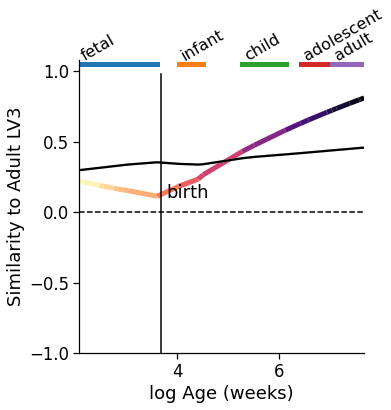

In [123]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C3'] = bs_subsum.loc[repplots_bs.index,'C3_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())
# invert
rtall_bs.loc[:,'value'] = rtall_bs.loc[:,'value'].values * -1
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=(repplots_bs[repcols].mean(1).values*-1),
            color='black',#line_kws={'ls':'--'},
           marker='',lowess=True)

m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C3.values,
            color='gray',
           marker='',lowess=True)

x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='magma_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()

plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C3_17Clu15vAll_BS.pdf'),
#             bbox_inches='tight')

# Primate
Finally, it would be great to try to replicate these genes in the primate dataset as well. This is tricky however because developmental time is different for macaques and humans. Luckily the Zhu et al., 2018 paper addresses this and offers developmental "periods" that are aligned with previously described human developmental periods. We assign the humans and macaques to aligned developmental periods and then just plot each LV and the genes

#### New mapping

In [124]:
# stage, based on Zhu et al., 2018
s4 = ['E60']
s5 = ['E80','E81','E82']
s7 = ['E110','E111']
s8 = ['P0','P2']
s10 = ['7M','1Y']
s12 = ['2Y','3.5Y','4Y','5Y','7Y']
s13 = ['11Y']
divs = [s4,s5,s7,s8,s10,s12,s13]
names = [4,5,7,8,10,12,13]
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    subsum.loc[subsum[(subsum.Age.isin(div)) & (subsum.Species=='Macaque')
                     ].index,'Period'] = name

Now that we have the shared mapping, let's merge the PEC and Brainspan datasets

In [125]:
combined = pandas.DataFrame(subsum[['Brain','Species','Period',
                                   'C1_r','C2_r','C3_r']],
                           copy=True)
combined.columns = ['Brain','Species','Period','LV1_r','LV2_r','LV3_r']
combined.loc[:,'Species'] = ['PEC '+x for x in combined.Species.values]
combined

,Brain,Species,Period,LV1_r,LV2_r,LV3_r
HSB103,HSB103,PEC Human,4.0,0.891309,-0.059911,0.398958
HSB107,HSB107,PEC Human,6.0,0.733492,0.328259,0.795981
HSB112,HSB112,PEC Human,2.0,0.673625,0.407330,0.422063
HSB113,HSB113,PEC Human,3.0,0.951497,0.222249,0.439873
HSB114,HSB114,PEC Human,4.0,0.341195,0.504577,-0.124464
...,...,...,...,...,...,...
RMB227,RMB227,PEC Macaque,5.0,NaN,NaN,NaN
RMB228,RMB228,PEC Macaque,4.0,0.770472,0.197544,0.280818
RMB233,RMB233,PEC Macaque,7.0,0.827185,0.043031,0.168609
RMB291,RMB291,PEC Macaque,10.0,0.963077,0.533361,0.579521


In [126]:
bsubsum = pandas.read_csv('data/subsum.csv',
                         index_col=0)
tocombine = pandas.DataFrame(bsubsum[['donor_id','Age_Period','C1_r','C2_r','C3_r']],
                            copy=True)
tocombine.columns = ['Brain','Period','LV1_r','LV2_r','LV3_r']
tocombine.loc[:,'Species'] = 'BS Human'
tocombine.loc[:,'Period'] = [float(x.split('p')[1]) for x in tocombine.Period.values]
combined = pandas.concat([combined,tocombine])

In [127]:
combined.index = combined.Brain.values

Finally, we redo the above analysis looking at similarity to adult LV expression, but this time with the data summarized by developmental periods

In [129]:
repsets = {1:['SPON2', 'SP5', 'ZIC1', 'TLL1', 'C14orf132', 'LIMK2', 'LGR6', 'CCDC88B'],
          2: ['FANK1', 'LRRN1', 'KCNA5', 'SKAP1', 'VWA5A', 'RBP1', 'SIX3', 'MGAT4C', 
              'HRH3', 'HSPB8', 'ZMYND10'],
          3: ['PID1']}

In [130]:
pecind = combined[combined.Species.isin(['PEC Human','PEC Macaque'])].index
bsind = combined[combined.Species=='BS Human'].index
for c in range(1,4):
    bsdf = pandas.read_csv('data/TESTBioInf_rvals_C%s_rotated.csv'%c,index_col=0)
    # create individual dfs for each component
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']  

    for gene in repsets[c]:
        combined.loc[bsind,gene+'_r'] = bsdf.loc[bsind,gene+'_r'].values
        if gene not in df.index: continue
        qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
        gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                      ].set_index(['Brain'],append=True
                                 ).pivot_table(index='Brain',
                                               columns='MacroStructure',
                                               values='C%sGene_exp'%c).loc[pecind]
        gpdf.drop('Transient',axis=1,inplace=True)
        for ind,row in gpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            gpdf.loc[ind,'n_valid'] = n_valid
        aba = aba.loc[gpdf.columns[:-1]]
        fail = False
        for i,row in gpdf.iterrows():
            forcorr = pandas.DataFrame(aba,copy=True)
            # if subject has 6+ regions with data
            if row['n_valid'] > 5:
                # find similarity to Allen expression
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                    fail = True
                    continue
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]

                 # store values
                gpdf.loc[i,'%s_r'%gene] = r

            # store per gene information for each subject -- r, rho and n_valid
        if fail == True: continue
        combined.loc[pecind,'%s_r'%gene] = gpdf.loc[pecind,'%s_r'%gene].values
        combined.loc[pecind,'n_valid'] = gpdf.loc[pecind,'n_valid'].values
    
    

In [131]:
# and once again invert PID1 for consistency
combined.loc[:,'PID1_r'] = combined.PID1_r.values *-1

I want to put this information together in one big plot. Because of the complexity of the individual plot and the way seaborn works, I'll need to do some prepratory steps...

In [132]:
combined.loc[:,'ind'] = range(len(combined))
gcols = [x for x in combined.columns if '_r' in x]
combtall = combined.melt(id_vars='ind',value_vars=gcols)
for col in ['Brain','Species','Period']:
    combtall.loc[:,col] = combined[col].tolist() * len(gcols)

In [135]:
for i,x in enumerate(product(list(range(4)),list(range(6)))):
    if i == 23: break
    gind = combtall[combtall.variable==gcols[i]].index
    combtall.loc[gind,'row'] = x[0]
    combtall.loc[gind,'col'] = x[1]

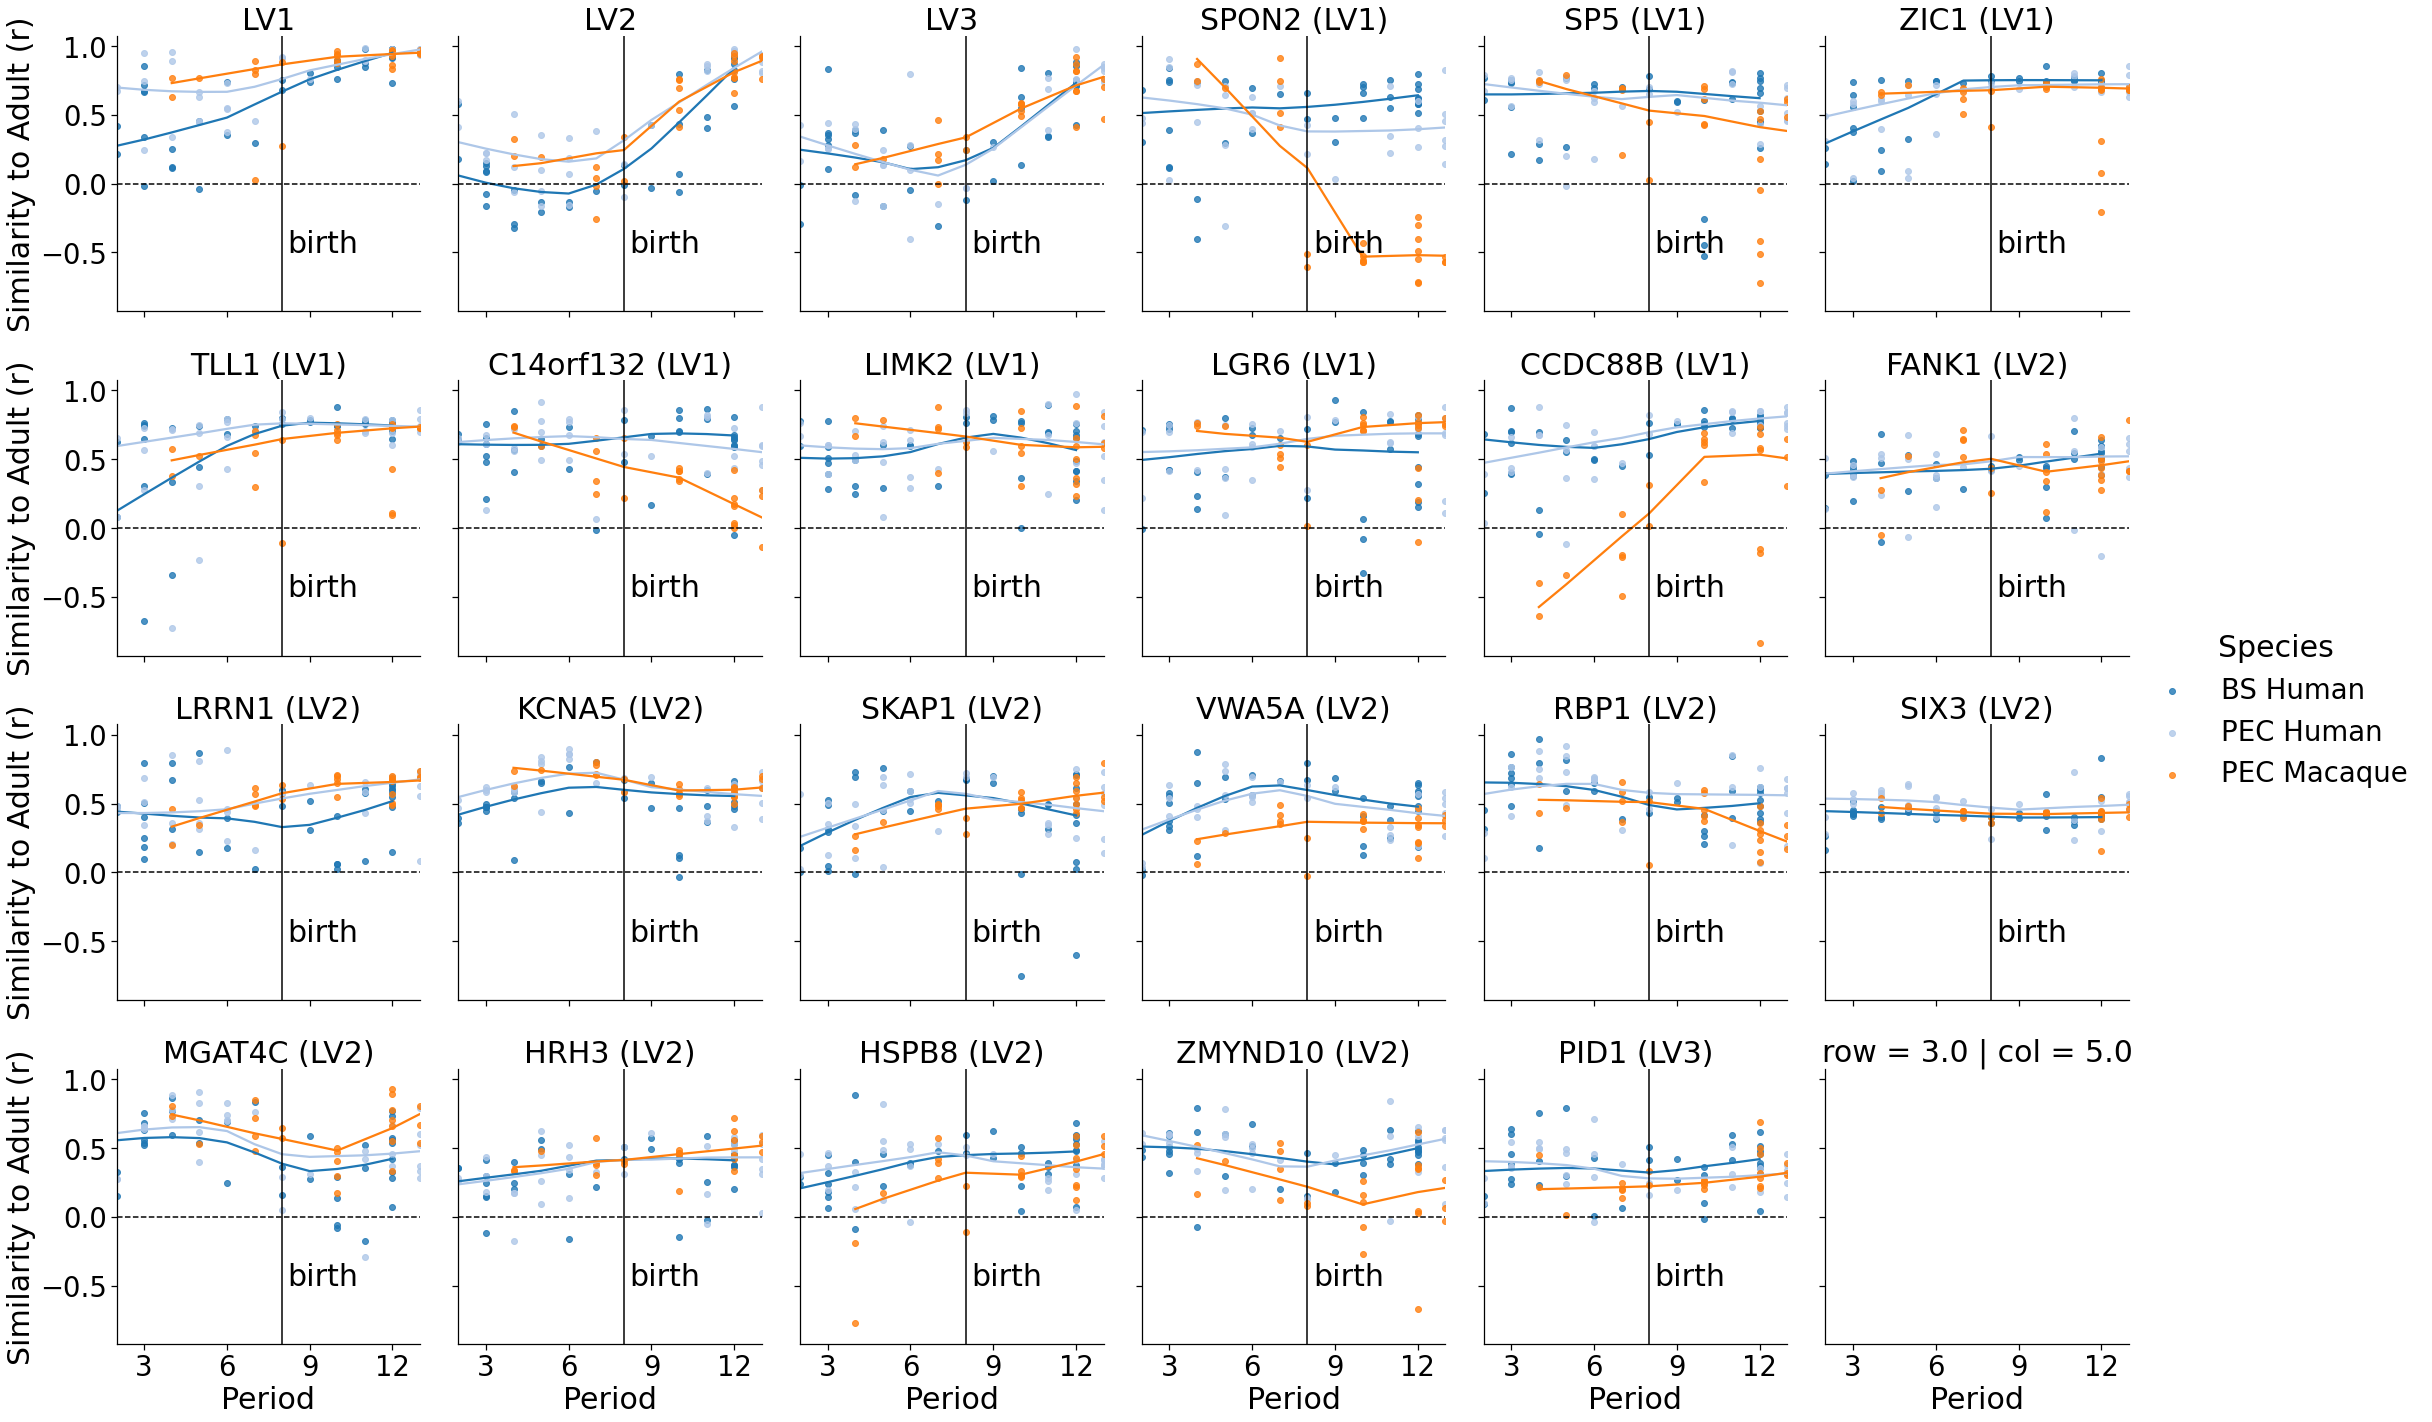

In [136]:
# now plot it all at once!!
with sns.plotting_context('notebook',font_scale=2.5):
    g = sns.lmplot(x='Period',y='value',hue='Species',lowess=True,
                   hue_order=['BS Human','PEC Human','PEC Macaque'],
              row='row',col='col',data=combtall,sharey=True,sharex=True,
                   palette='tab20')
    axes = g.axes.flatten()
    for i in range(len(gcols)):
        gene = gcols[i].split('_')[0]
        lv = [x for x in repsets.keys() if gene in repsets[x]]
        if len(lv) == 0:
            axes[i].set_title(gene)
        else:
            axes[i].set_title('%s (LV%s)'%(gene,lv[0]))
        axes[i].axhline(0,ls='--',c='k')
        axes[i].axvline(8,c='k')
        axes[i].text(8.2,-0.5,'birth')
        axes[i].set_xticks([3,6,9,12])
        if i%6==0:
            axes[i].set_ylabel('Similarity to Adult (r)')
    #plt.savefig(os.path.join(fig_dir,'GeneHomology_Facetgrid.pdf'),bbox_inches='tight')